## IMPORTING LIBRARIES

In [84]:
#importing the required libraries
# Libraries for data loading, data manipulation and data visulisation
import numpy as np                     
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
# Customise our plotting settings
sns.set_style('whitegrid')


#Libraries for data cleaning and preprocessing
from wordcloud import WordCloud, STOPWORDS , ImageColorGenerator
from nltk.tokenize import word_tokenize, TreebankWordTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils import resample
import string
import re
import pickle
import nltk

#Libraries for data preparation and model building

from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score # Classification report

## LOADING DATASET

In [85]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test_with_no_labels.csv") 

## EXPLORATORY DATA ANALYSIS (EDA)

In [86]:
train.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


In [87]:
train.tail()

,sentiment,message,tweetid
15814,1,RT @ezlusztig: They took down the material on ...,22001
15815,2,RT @washingtonpost: How climate change could b...,17856
15816,0,notiven: RT: nytimesworld :What does Trump act...,384248
15817,-1,RT @sara8smiles: Hey liberals the climate chan...,819732
15818,0,RT @Chet_Cannon: .@kurteichenwald's 'climate c...,806319


In [88]:
test.head()

,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326
2,"The scary, unimpeachable evidence that climate...",224985
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928


In [89]:
train.shape

(15819, 3)

In [90]:
train.describe()

,sentiment,tweetid
count,15819.000000,15819.000000
mean,0.917504,501719.433656
std,0.836537,289045.983132
min,-1.000000,6.000000
25%,1.000000,253207.500000
50%,1.000000,502291.000000
75%,1.000000,753769.000000
max,2.000000,999888.000000


In [91]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15819 entries, 0 to 15818
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  15819 non-null  int64 
 1   message    15819 non-null  object
 2   tweetid    15819 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 370.9+ KB


In [92]:
train.isnull().sum()

sentiment    0
message      0
tweetid      0
dtype: int64

In [93]:
train.nunique()

sentiment        4
message      14229
tweetid      15819
dtype: int64

In [94]:
duplicate_rows = train[train.duplicated()]
if not duplicate_rows.empty:
    print("Duplicate Rows:")
    print(duplicate_rows)
else:
    print("No duplicate rows found.")

No duplicate rows found.


In [95]:
sentiment_counts=train['sentiment'].value_counts()
print(sentiment_counts)

 1    8530
 2    3640
 0    2353
-1    1296
Name: sentiment, dtype: int64


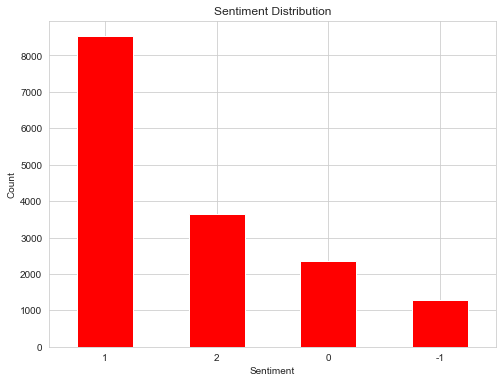

In [96]:
plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', color='red')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

## WORDCLOUD VISUALISATION

(-0.5, 399.5, 199.5, -0.5)

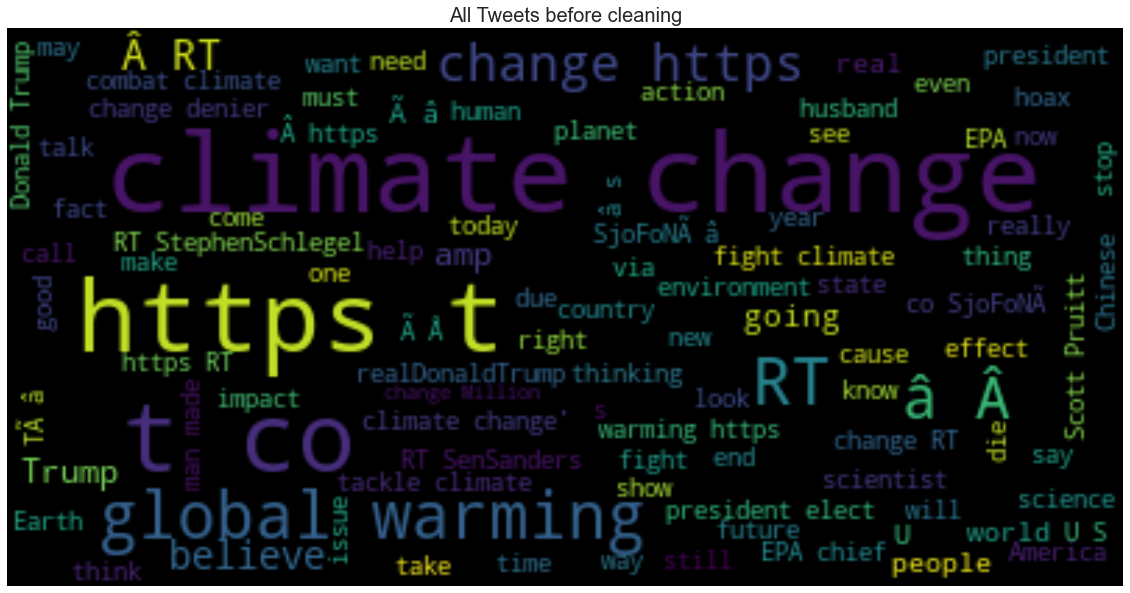

In [97]:
tweet_All = " ".join(review for review in train.message)


fig, ax = plt.subplots(figsize  = (20,30))
# Create and generate a word cloud image:
wordcloud_ALL = WordCloud(max_font_size=40, max_words=100, background_color="black").generate(tweet_All)

# Display the generated image:
ax.imshow(wordcloud_ALL, interpolation='bilinear')
ax.set_title('All Tweets before cleaning', fontsize=20)
ax.axis('off')


## Data processing

In [98]:
def hashtag_extract(tweets):
    """
    The function takes in tweets as input and extracts the hashtag from the tweets
    using (re) and returns the hashtags
    
    """
    hashtags=[]
    tweets=tweets.to_list()
    for tweet in tweets:
        hashtag = re.findall(r"#(\w+)",tweet)
        hashtags.append(hashtag)
    return hashtags

In [99]:
# Extract Hashtags for pro climate change 
pro_climate = hashtag_extract(train['message'][train['sentiment']==1])

# Extract Hashtags for anti climate change 
anti_climate = hashtag_extract(train['message'][train['sentiment']==-1])

In [100]:
# un-nest the lists
pro_climate = sum(pro_climate, [])
anti_climate = sum(anti_climate, [])

In [101]:
# Remove Punctuation
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [102]:
#Data preprocessing
#function that handles the removal punctuations from the tweets
def remove_punct(text):
    """
    the function remove_punction, it takes in a text as input and loops through
    the text, if a character is not in string.punctuation then it adds the character
    as a string to the text variable
    
    """
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text

In [103]:
#removes all websites and replaces them with the text 'web-url'
pattern_url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
subs_url = r'url-web'
train['message_punct'] = train['message'].replace(to_replace = pattern_url, value = subs_url, regex = True)


In [104]:
# Data cleaning 
def clean_data(texts):
    
    """
    clean_data(text), the function further cleans the data using (re)
    by removing extract white spaces and non text characters
    
    """
    words = list()
    for text in texts.split():
        # remove non text character from start and end of string
        text = re.sub(r'(^\W+|\W+$)','',text)
#       #remove multiple white spaces
        text = re.sub(r'\s+','',text)
#       #remove non text characters and emojis between texts
        text = re.sub(r'\W+',r'',text)
#       #remove white space at the end of strings
        text = re.sub(r'\s+$',r'',text)
#       #Remove unwanted symbols
        text = re.sub(r'[#,@,$_,?*//""]',r'',text)
        words.append(text.lower())
            
        text = [i for i in words if len(i) >= 2]

    return " ".join(text)

In [105]:
#applying the clean_data function
train['tweets'] = train['message_punct'].apply(clean_data)

In [106]:
train.head()

,sentiment,message,tweetid,message_punct,tweets
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,PolySciMajor EPA chief doesn't think carbon di...,polyscimajor epa chief doesnt think carbon dio...
1,1,It's not like we lack evidence of anthropogeni...,126103,It's not like we lack evidence of anthropogeni...,its not like we lack evidence of anthropogenic...
2,2,RT @RawStory: Researchers say we have three ye...,698562,RT @RawStory: Researchers say we have three ye...,rt rawstory researchers say we have three year...
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,#TodayinMaker# WIRED : 2016 was a pivotal year...,todayinmaker wired 2016 was pivotal year in th...
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",rt soynoviodetodas its 2016 and racist sexist ...


## WORDCLOUD ON CLEAN DATA

(-0.5, 399.5, 199.5, -0.5)

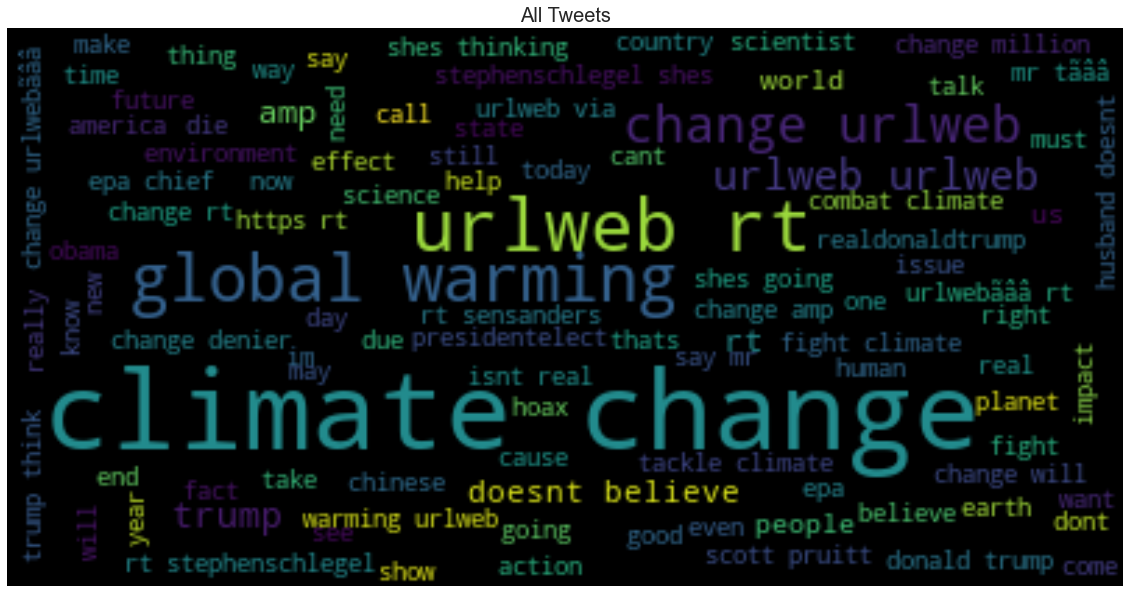

In [107]:
# Start with one review:
#looping through each category of the tweet and joining it as a string
tweet_All = " ".join(review for review in train.tweets)


fig, ax = plt.subplots(figsize  = (20,30))
# Create and generate a word cloud image:
wordcloud_ALL = WordCloud(max_font_size=40, max_words=100, background_color="black").generate(tweet_All)

# Display the generated image:
ax.imshow(wordcloud_ALL, interpolation='bilinear')
ax.set_title('All Tweets', fontsize=20)
ax.axis('off')


## DATA ENGINEERING

In [108]:
new_data = train


In [109]:
print(new_data.shape[1])  # This will print the number of columns in the DataFrame


5


## MODELLING

In [110]:
X = new_data.iloc[: , :4]
y = new_data.iloc[: , 4]

In [111]:
# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train['message'], train['sentiment'], test_size=0.2, random_state=42)


In [112]:
# Model Selection
# Choose and initialize a machine learning model (e.g., Logistic Regression)
model = LogisticRegression()


In [113]:
# Train the model
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
model.fit(X_train_tfidf, y_train)

C:\Users\nah\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [79]:
# Evaluation
# Evaluate the model on the validation set
X_val_tfidf = tfidf_vectorizer.transform(X_val)
y_pred = model.predict(X_val_tfidf)
f1 = f1_score(y_val, y_pred, average='macro')
print('Validation F1 Score:', f1)

Validation F1 Score: 0.6148922237279513


In [82]:
# Prediction
# Load the test dataset
test= pd.read_csv("test_with_no_labels.csv") 
test.head()

,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326
2,"The scary, unimpeachable evidence that climate...",224985
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928


In [115]:
# Use the trained model to predict sentiment on the test dataset
X_test_tfidf = tfidf_vectorizer.transform(test['message'])
test_predictions = model.predict(X_test_tfidf)

In [117]:
# Submission
# Format the predictions according to the required submission format and save to a CSV file
submission_df = pd.DataFrame({'tweetid': test['tweetid'], 'sentiment': test_predictions})
submission_df.to_csv('submission2.csv', index=False)